In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [ ]:
df=pd.read_csv('AAPL.csv', parse_dates=['Date'],index_col=['Date'])

In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...
2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100


# Nomor 1a

Saham AAPL memiliki harga terendahnya pada tahun 1982 dengan harga 0.19, sedangkan harga tertinggi pada tahun 2020 dengan harga 327.

In [ ]:
min_value = df['Close'].min()
max_value = df['Close'].max()

min_date = df['Close'].idxmin()
max_date = df['Close'].idxmax()

print("Nilai Minimum:", min_value, "pada tanggal:", min_date)
print("Nilai Maksimum:", max_value, "pada tanggal:", max_date)

Nilai Minimum: 0.1964285671710968 pada tanggal: 1982-07-08 00:00:00
Nilai Maksimum: 327.20001220703125 pada tanggal: 2020-02-12 00:00:00


seiiring berjalannya waktu, harga saham AAPL mengalami fluktuasi yang menyebabkan banyaknya harga yang terindikasi sebagai outliers berdasarkan IQR nya. sebesar 15% dari keseluruhan harga merupakan outliers. dimana outliers dalam kasus ini adalah harga saham yang diatas rata-rata.

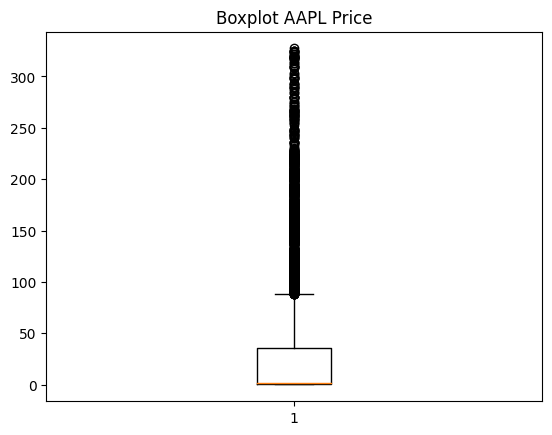

Jumlah data : 9909
Jumlah outliers : 1539
Persentase outliers : 15.531335149863759 %


In [ ]:
close_prices = df['Close']

Q1 = np.percentile(close_prices, 25)
Q3 = np.percentile(close_prices, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = close_prices[(close_prices < lower_bound) | (close_prices > upper_bound)]

plt.boxplot(close_prices)
plt.title('Boxplot AAPL Price')
plt.show()

print("Jumlah data :", len(close_prices))
print("Jumlah outliers :", len(outliers))
print("Persentase outliers :", len(outliers)/len(close_prices)*100,"%")

Berdasarkan plot dekomposisi dibawah ini terdapat beberapa insight yakni :


**Trend**:

Tren jangka panjang sangat bullish, dengan pertumbuhan eksponensial terutama sejak tahun 2010.
Harga saham meningkat dari sekitar 0 pada tahun 1980 ke lebih dari 300 pada tahun 2020.
Volatilitas meningkat seiring dengan kenaikan harga, terlihat dari fluktuasi yang lebih besar di tahun-tahun terakhir.


**Seasonal**:

Pola musiman konsisten sepanjang periode, dengan amplitudo sekitar 3 unit (-1.5 ke 1.5).
Siklus musiman terlihat berulang setiap tahun, menunjukkan adanya pola tahunan dalam pergerakan harga.
Dampak musiman relatif kecil dibandingkan dengan tren keseluruhan, tapi tetap konsisten.


**Residual**:

Volatilitas residual meningkat drastis seiring waktu, terutama setelah tahun 2010 dimana terjadi resesi ekonomi global.
Fluktuasi terbesar terlihat di akhir periode terutama di tahun 2019 diasumsikan akibat wabah COVID-19, dengan swing hingga sekitar 40 unit.
Periode awal (1980-2000) menunjukkan residual yang relatif stabil, menandakan pasar yang lebih tenang.


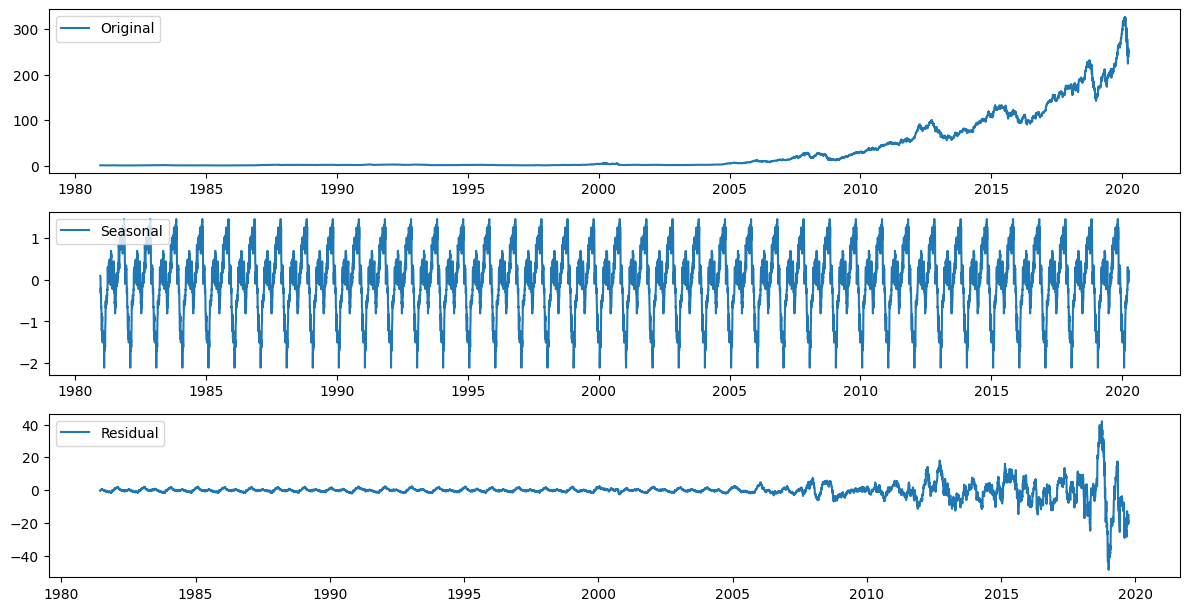

In [ ]:
result = seasonal_decompose(df['Close'], model='additive', period=252)  # Misalnya, menggunakan model additive dengan periode 12

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['Close'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Nilai statistik dibawah ini dibuat untuk menguji hipotesis awal dimana :
- H0 = Data berisi unit root
- H1 = Data tidak berisi unit root

Jika terdapat unit root dalam data, maka data tidak stasioner (tidak memiliki mean atau varians yang konstan).

significant level pada ADF tanpa parameter tambahan adalah 0.05 (-2.862)

1. ADF Statistic (1.89) > Significant Level (-2.86), maka kita tidak memiliki cukup bukti untuk menolak H0.
2. P-Value (0.99) > Significant Level (0.05), maka kita tidak memiliki cukup bukti untuk menolak H0.

Kesimpulannya, data time series yang kita miliki bersifat **stasioner** dimana data memiliki mean atau varians yang konstan.

In [ ]:
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 1.893973846826086
p-value: 0.9985182618845982


Splitting Time Series Dataset


disini saya memisahkan dataset menjadi 80:10:10 dimana 80% menjadi data train, 10% menjadi data val, dan 10% terakhir menjadi data test.

In [ ]:
df.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df.columns

Index(['Close'], dtype='object')

In [ ]:
def create_windows(data, window_size, horizon):
    windows = []
    for i in range(len(data) - window_size - horizon + 1):
        input_window = data.iloc[i:i+window_size]['Close'].values
        output_window = data.iloc[i+window_size:i+window_size+horizon]['Close'].values
        windows.append((input_window, output_window))
    return windows

df_windows = create_windows(df, window_size=5, horizon=1)

def split_data(windows, train_ratio, val_ratio):
    n = len(windows)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train_data = windows[:train_end]
    val_data = windows[train_end:val_end]
    test_data = windows[val_end:]

    return train_data, val_data, test_data

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train, val, test = split_data(df_windows, train_ratio, val_ratio)

print(f"AAPL Data - Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")
def prepare_data(windows):
    X = np.array([window[0] for window in windows])
    y = np.array([window[1] for window in windows])
    return X, y

X_train, y_train = prepare_data(train)
X_val, y_val = prepare_data(val)
X_test, y_test = prepare_data(test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

AAPL Data - Train: 7923, Validation: 990, Test: 991


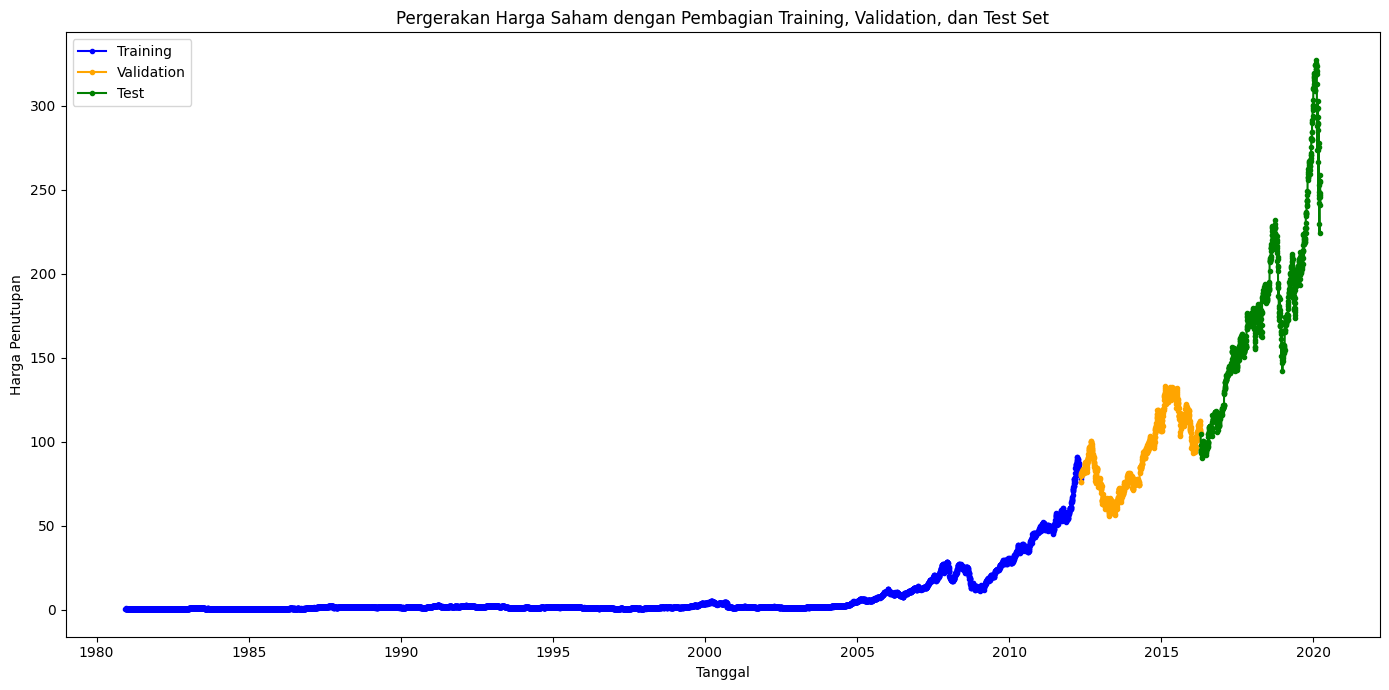

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df.index[:len(y_train)], y_train, marker='.', label='Training', color='blue')
plt.plot(df.index[len(y_train):len(y_train)+len(y_val)], y_val, marker='.', label='Validation', color='orange')
plt.plot(df.index[len(y_train)+len(y_val):len(y_train)+len(y_val)+len(y_test)], y_test, marker='.', label='Test', color='green')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.title('Pergerakan Harga Saham dengan Pembagian Training, Validation, dan Test Set')
plt.legend()
plt.tight_layout()
plt.show()

# Nomor 1b

In [ ]:
model = Sequential()

model.add(LSTM(units=50, input_shape=(5, 1), activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mae', metrics=RootMeanSquaredError())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val)
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
248/248 [==============================] - 4s 8ms/step - loss: 0.8291 - root_mean_squared_error: 3.4590 - val_loss: 2.1742 - val_root_mean_squared_error: 2.5531
Epoch 2/50
248/248 [==============================] - 1s 6ms/step - loss: 0.1840 - root_mean_squared_error: 0.4507 - val_loss: 1.5509 - val_root_mean_squared_error: 2.0368
Epoch 3/50
248/248 [==============================] - 2s 6ms/step - loss: 0.1724 - root_mean_squared_error: 0.4102 - val_loss: 1.4473 - val_root_mean_squared_error: 1.8615
Epoch 4/50
248/248 [==============================] - 1s 6ms/step - loss: 0.1781 - root_mean_squared_error: 0.4284 - val_loss: 1.1732 - val_root_mean_squared_error: 1.6007
Epoch 5/50
248/248 [==============================] - 1s 5ms/step - loss: 0.1561 - root_mean_squared_error: 0.3842 - val_loss: 1.1490 - val_root_mean_squared_error: 1.5825
Epoch 6/50
248/248 [==============================] - 1s 6ms/step - loss: 0.1605 - root_mean_squared_error: 0.3946 - val_loss: 5.4774 - val_

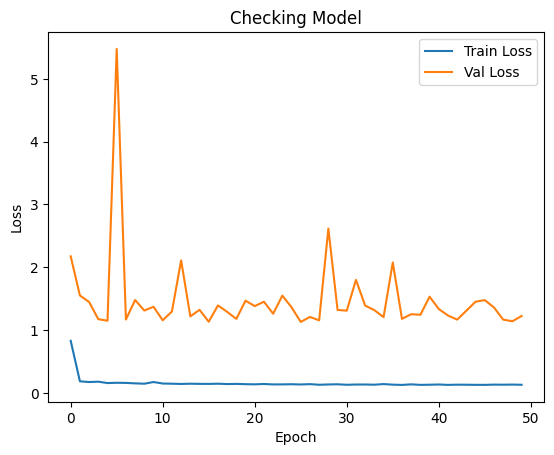

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.title("Checking Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

31/31 [==============================] - 0s 2ms/step
RMSE: 5.3235
MAE: 3.8501
MAPE: 2.0000%


# Nomor 1c

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(units=150, activation='relu', return_sequences=True), input_shape=(5, 1)))
model.add(Bidirectional(LSTM(units=50, activation='relu')))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mae', metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 300)            182400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               140400    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 322901 (1.23 MB)
Trainable params: 322901 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    #batch_size=64,
                    validation_data=(X_val, y_val)
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
248/248 [==============================] - 13s 36ms/step - loss: 0.5033 - root_mean_squared_error: 2.2689 - val_loss: 1.9463 - val_root_mean_squared_error: 2.5282
Epoch 2/50
248/248 [==============================] - 6s 24ms/step - loss: 0.2355 - root_mean_squared_error: 0.5828 - val_loss: 1.8505 - val_root_mean_squared_error: 2.3763
Epoch 3/50
248/248 [==============================] - 8s 31ms/step - loss: 0.2389 - root_mean_squared_error: 0.6004 - val_loss: 1.6511 - val_root_mean_squared_error: 2.1556
Epoch 4/50
248/248 [==============================] - 6s 25ms/step - loss: 0.2116 - root_mean_squared_error: 0.5177 - val_loss: 2.6972 - val_root_mean_squared_error: 3.2597
Epoch 5/50
248/248 [==============================] - 7s 30ms/step - loss: 0.2114 - root_mean_squared_error: 0.5174 - val_loss: 1.6198 - val_root_mean_squared_error: 2.0885
Epoch 6/50
248/248 [==============================] - 6s 26ms/step - loss: 0.2265 - root_mean_squared_error: 0.5488 - val_loss: 2.1177

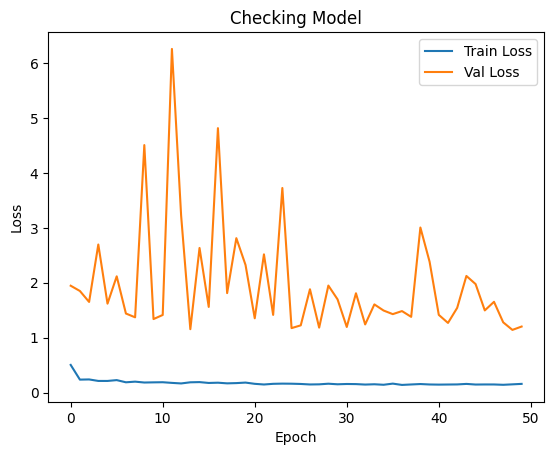

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.title("Checking Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Nomor 1d

In [ ]:
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")

31/31 [==============================] - 1s 14ms/step
RMSE: 4.6747
MAE: 3.1201
MAPE: 1.6200%


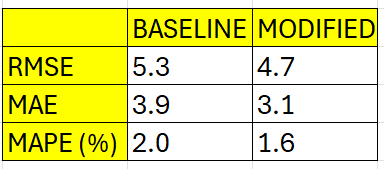

**Performa Metrik:**

Model modifikasi menghasilkan nilai RMSE dan MAE yang lebih rendah dibandingkan dengan baseline. Ini menunjukkan bahwa model modifikasi cenderung memberikan prediksi yang lebih akurat secara keseluruhan.
Model modifikasi juga memiliki MAPE yang lebih rendah, menunjukkan bahwa persentase kesalahan relatif terhadap nilai aktual lebih kecil.


**Arsitektur Model:**

Penggunaan dua layer Bidirectional LSTM pada model modifikasi dapat membantu model untuk lebih baik dalam menangkap pola dan dependensi dalam data time series yang kompleks seperti harga saham AAPL.
Penambahan jumlah unit pada layer pertama (150 unit) dan layer kedua (50 unit) pada model modifikasi juga dapat meningkatkan kapasitas model untuk memahami dan memodelkan data yang lebih kompleks.


**Kesimpulan:**

Model modifikasi menunjukkan perbaikan yang signifikan dalam metrik evaluasi dibandingkan dengan baseline, dengan penurunan yang konsisten dalam RMSE, MAE, dan MAPE. Ini menunjukkan bahwa arsitektur yang lebih kompleks dengan penggunaan Bidirectional LSTM dapat memberikan manfaat dalam memodelkan time series seperti harga saham AAPL.